<a href="https://colab.research.google.com/github/d-roland/toxicityDetection/blob/main/CS224n_Toxicity_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import csv
from tqdm import tqdm, trange
from collections import Counter, defaultdict
from wordcloud import WordCloud
import string
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
import gensim
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Concatenate, concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from datetime import datetime
from statistics import mean
import random

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using TensorFlow backend.


In [3]:

from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

### Loading and merging datasets

In [4]:
colnames=['Sentence', 'Type', 'Level', 'Target'] 
hateful = pd.read_csv('/content/drive/My Drive/CS224n_Project/Hatefuls.csv', names=colnames, header=None)
hateful.shape

(194593, 4)

In [5]:
hateful.describe()

,Sentence,Type,Level,Target
count,194572,194593,194593,194593
unique,63324,14,4,6
top,tg,Insult,VERY_HIGH,USER
freq,1364,116947,66901,96997


In [6]:
#Adding a class column prior to merging with neutral data
hateful["Class"] = 1
hateful.head()

,Sentence,Type,Level,Target,Class
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1
3,T un kiko mdr,Insult,LOW,USER,1
4,Moi mdr t trop nul,Hate,LOW,USER,1


In [7]:
hateful.Sentence = hateful.Sentence.astype(str)

In [8]:
neutral = pd.read_csv('/content/drive/My Drive/CS224n_Project/Neutrals_200k.csv', names=colnames, header=None)
neutral.shape

(200000, 4)

In [9]:
neutral.Sentence = neutral.Sentence.astype(str)

In [10]:
#Adding a class column prior to merging with toxic data
neutral["Class"] = 0
neutral.head()

,Sentence,Type,Level,Target,Class
0,"Chui désolé, mais quand un film de science-fic...",Neutral,NONE,UNDEFINED,0
1,Mdrrr junior bvndo,Neutral,NONE,UNDEFINED,0
2,baham je taimz,Neutral,NONE,UNDEFINED,0
3,Meilleurs rappeurs de tout les temps 😂😂😂 je ri...,Neutral,NONE,UNDEFINED,0
4,7up❤️,Neutral,NONE,UNDEFINED,0


In [11]:
dataset = hateful.append([neutral], ignore_index=True)
dataset.shape

(394593, 5)

In [12]:
dataset.head()

,Sentence,Type,Level,Target,Class
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1
3,T un kiko mdr,Insult,LOW,USER,1
4,Moi mdr t trop nul,Hate,LOW,USER,1


In [13]:
dataset.tail()

,Sentence,Type,Level,Target,Class
394588,@studiosushi @Chitori_Bocchi evangelionnnnnnnn...,Neutral,NONE,UNDEFINED,0
394589,J'ai kiffer les 2 Baby sitter c drôle et horri...,Neutral,NONE,UNDEFINED,0
394590,Moi aussi je t'ai demandé si tu étais la premi...,Neutral,NONE,UNDEFINED,0
394591,venez on fait l' aphalbet,Neutral,NONE,UNDEFINED,0
394592,Bah oui 80% de la police france est pro RN ...,Neutral,NONE,UNDEFINED,0


### Analyzing dataset

In [14]:
dataset.groupby(['Target']).count()

,Sentence,Type,Level,Class
Target,,,,
AUTHOR_OF_COMMENT,2547,2547,2547,2547
EVERYONE,16603,16603,16603,16603
GROUP,36083,36083,36083,36083
NO_ONE,1,1,1,1
SINGLE_PERSON,36128,36128,36128,36128
UNDEFINED,199191,199191,199191,199191
USER,97574,97574,97574,97574
USER_FAMILY,6466,6466,6466,6466


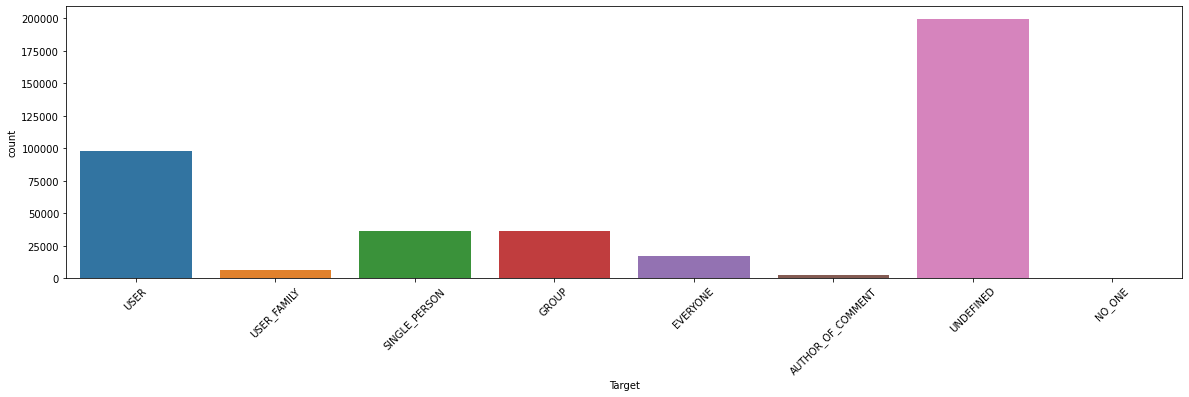

In [15]:
plt.figure(figsize=(20,5))
chart = sns.countplot("Target", data=dataset)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [16]:
dataset.groupby(['Type']).count()

,Sentence,Level,Target,Class
Type,,,,
Ads,27,27,27,27
Critics,15,15,15,15
Hate,37293,37293,37293,37293
Homophobia,12256,12256,12256,12256
Insult,116947,116947,116947,116947
Misogyny,6,6,6,6
Mockery,13950,13950,13950,13950
Moral Harassment,1583,1583,1583,1583
Neutral,200009,200009,200009,200009


In [17]:
dataset.groupby(['Level']).count()

,Sentence,Type,Target,Class
Level,,,,
HIGH,53358,53358,53358,53358
LOW,28016,28016,28016,28016
MEDIUM,46880,46880,46880,46880
NONE,199189,199189,199189,199189
VERY_HIGH,67150,67150,67150,67150


In [18]:
dataset_stats = dataset.groupby(['Target', 'Level']).size().reset_index(name='count')
pd.pivot_table(dataset_stats, index=['Level'], columns = ['Target'],values=['count'], fill_value=0)

count                 ...                             
Target    AUTHOR_OF_COMMENT EVERYONE GROUP  ... UNDEFINED   USER USER_FAMILY
Level                                       ...                             
HIGH                    189     3952  9004  ...         4  27624        3577
LOW                    1350     2743  9031  ...         1   5481         378
MEDIUM                  837     2125  9036  ...        14  24422        1413
NONE                      0        4     0  ...    199171     13           0
VERY_HIGH               171     7779  9012  ...         1  40034        1098

[5 rows x 8 columns]

In [19]:
#Checking if empty Sentences exist
empty_index = [index for index,text in enumerate(dataset.Sentence.values) if str(text).strip() == '']
print("No of empty rows: {}".format(len(empty_index)))
hateful.iloc[empty_index].tail()

No of empty rows: 0


,Sentence,Type,Level,Target,Class


In [20]:
#Removing row with "NO_ONE" target
dataset[dataset['Target']=="NO_ONE"]
dataset = dataset.drop(dataset[dataset['Target']=="NO_ONE"].index)

In [21]:
#Checking frequent words
cnt = Counter()
for text in dataset["Sentence"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('de', 212725),
 ('la', 117592),
 ('et', 104727),
 ('le', 99444),
 ('les', 94956),
 ('pas', 85171),
 ('que', 81618),
 ('des', 72993),
 ('à', 66654),
 ('un', 63619),
 ('a', 58883),
 ('je', 58172),
 ('pour', 57210),
 ('en', 56610),
 ('qui', 55488),
 ('est', 54054),
 ('tu', 51424),
 ('vous', 42380),
 ('une', 41758),
 ('il', 39910)]

In [22]:
#Checking average sentence length vs toxicity level
dataset['Length'] = dataset['Sentence'].apply(len)
#fig,(ax1, ax2) = plt.subplots(1,2)
#sns.barplot('Level','Length',data = dataset,palette='PRGn',ax=ax1).set_title('Avg Sentence Length vs Level')
#sns.barplot('Target','Length',data = dataset,palette='PRGn',ax=ax2).set_title('Avg Sentence Length vs Target')
#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
#plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
#fig.tight_layout()

In [23]:
#Checking average word number vs toxicity level
dataset['Count'] = dataset['Sentence'].str.split().str.len()
#fig,(ax1, ax2) = plt.subplots(1,2)
#sns.barplot('Level','Count',data = dataset,palette='PRGn',ax=ax1).set_title('Average Word Count vs Level')
#sns.barplot('Target','Count',data = dataset,palette='PRGn',ax=ax2).set_title('Average Word Count vs Target')
#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
#plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
#fig.tight_layout()

### Cleaning dataset

In [24]:
#Lowering all sentences

dataset['cleanSentence'] = dataset['Sentence'].apply(lambda x: x.lower())
dataset.head()

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo 😂😂🥃
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t’es vilain 😂😂😂😂😂😂
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d'île je m'abonne à ta chaine...
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul


In [25]:
#Dealing with emojis
!pip install emoji
import emoji

#does the text contain an emoji?
def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI["en"]:
            return True
    return False

#extract emojis for possible future use
def extract_emoji(text):
    emoji_list = []
    data = re.findall(r'[^\w\s,]', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI["en"] for char in word):
            emoji_list.append(word)
    return emoji_list

#remove the emoji
def remove_emoji(text):
  data = re.findall(r'[^\w\s,]', text)
  for word in data:
      if any(char in emoji.UNICODE_EMOJI["en"] for char in word):
          text = text.replace(word, '')
  return text

# Checking if emoji in source Sentence
dataset['Emoji'] = dataset['Sentence'].apply(extract_emoji)

# Removing Emojis from Sentence
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_emoji)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t’es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d'île je m'abonne à ta chaine...,[]
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[]
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[]
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂]
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[]
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c'est quoi cette mode ou presque tout les yout...,[]
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,@vittoremorgane @crdsar et ? il est au dessus ...,[]


In [135]:
#Extracting list of unique emojis
import itertools
emoji_list = np.unique([*itertools.chain.from_iterable(dataset.Emoji)])
print(emoji_list)

['©' '®' '‼' ... '\U0001fab6' '\U0001fad0' '\U0001fad2']


In [137]:
#ALTERNATIVE: convert emojis to corresponding text (to keep their spirit)


def convert_emojis(text):
    for emot in emoji.UNICODE_EMOJI["en"]:
        text = re.sub(r'('+emot+')', "_".join(emoji.UNICODE_EMOJI["en"][emot].replace(",","").replace(":","").split()), text)
    return text


In [27]:
#Special characters cleaning
"""
A utility function to remove numerical characters from the text.

"""

def remove_nums(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text


"""
A utility function to remove URL links from the text.

"""

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


"""
A utility function to remove HTML tags from the text.

"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


"""
A utility function to remove @

"""

def remove_special(text):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^ \nA-Za-z0-9À-ÖØ-öø-ÿ/ \t])", " ",text).split())
#    return " ".join(re.sub("(@[^\s]+)", " ",text).split())


#dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_nums)
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_URL)
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_html)
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_special)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[]
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[]
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[]
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂]
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[]
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[]
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[]


In [28]:
#Removing punctuation
punct =[]
punct += list(string.punctuation)
punct += '’'
punct.remove("'")

def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_punctuations)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[]
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[]
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[]
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂]
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[]
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[]
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[]


In [29]:
#Checking frequent words
cnt = Counter()
for text in dataset["cleanSentence"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('de', 219669),
 ('est', 133579),
 ('la', 130991),
 ('et', 120552),
 ('le', 113016),
 ('les', 106419),
 ('c', 95209),
 ('pas', 92356),
 ('que', 84686),
 ('je', 80306),
 ('des', 77273),
 ('a', 76027),
 ('un', 75793),
 ('en', 73365),
 ('à', 70458),
 ('il', 67932),
 ('tu', 65680),
 ('pour', 61827),
 ('qui', 58492),
 ('l', 55957)]

In [30]:
#Removing stopwords
STOPWORDS = nltk.corpus.stopwords.words('french')
#STOPWORDS = set(nltk.corpus.stopwords.words('english')) | set(nltk.corpus.stopwords.words('french'))

dataset_wo_stop = dataset.copy()

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

dataset_wo_stop['cleanSentence'] = dataset_wo_stop['cleanSentence'].apply(remove_stopwords)
dataset_wo_stop.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,bo,"[😂, 😂, 🥃]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,vilain,"[😂, 😂, 😂, 😂, 😂, 😂]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,propose île abonne chaine abonner chaîne youtu...,[]
3,T un kiko mdr,Insult,LOW,USER,1,13,4,kiko mdr,[]
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,mdr trop nul,[]
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,mono sourcils,[😂]
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[]
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce gamin,"[😂, 😂]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,quoi cette mode presque tout youtubeurs joue j...,[]
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,dessus lois fais reunions travail tous jours v...,[]


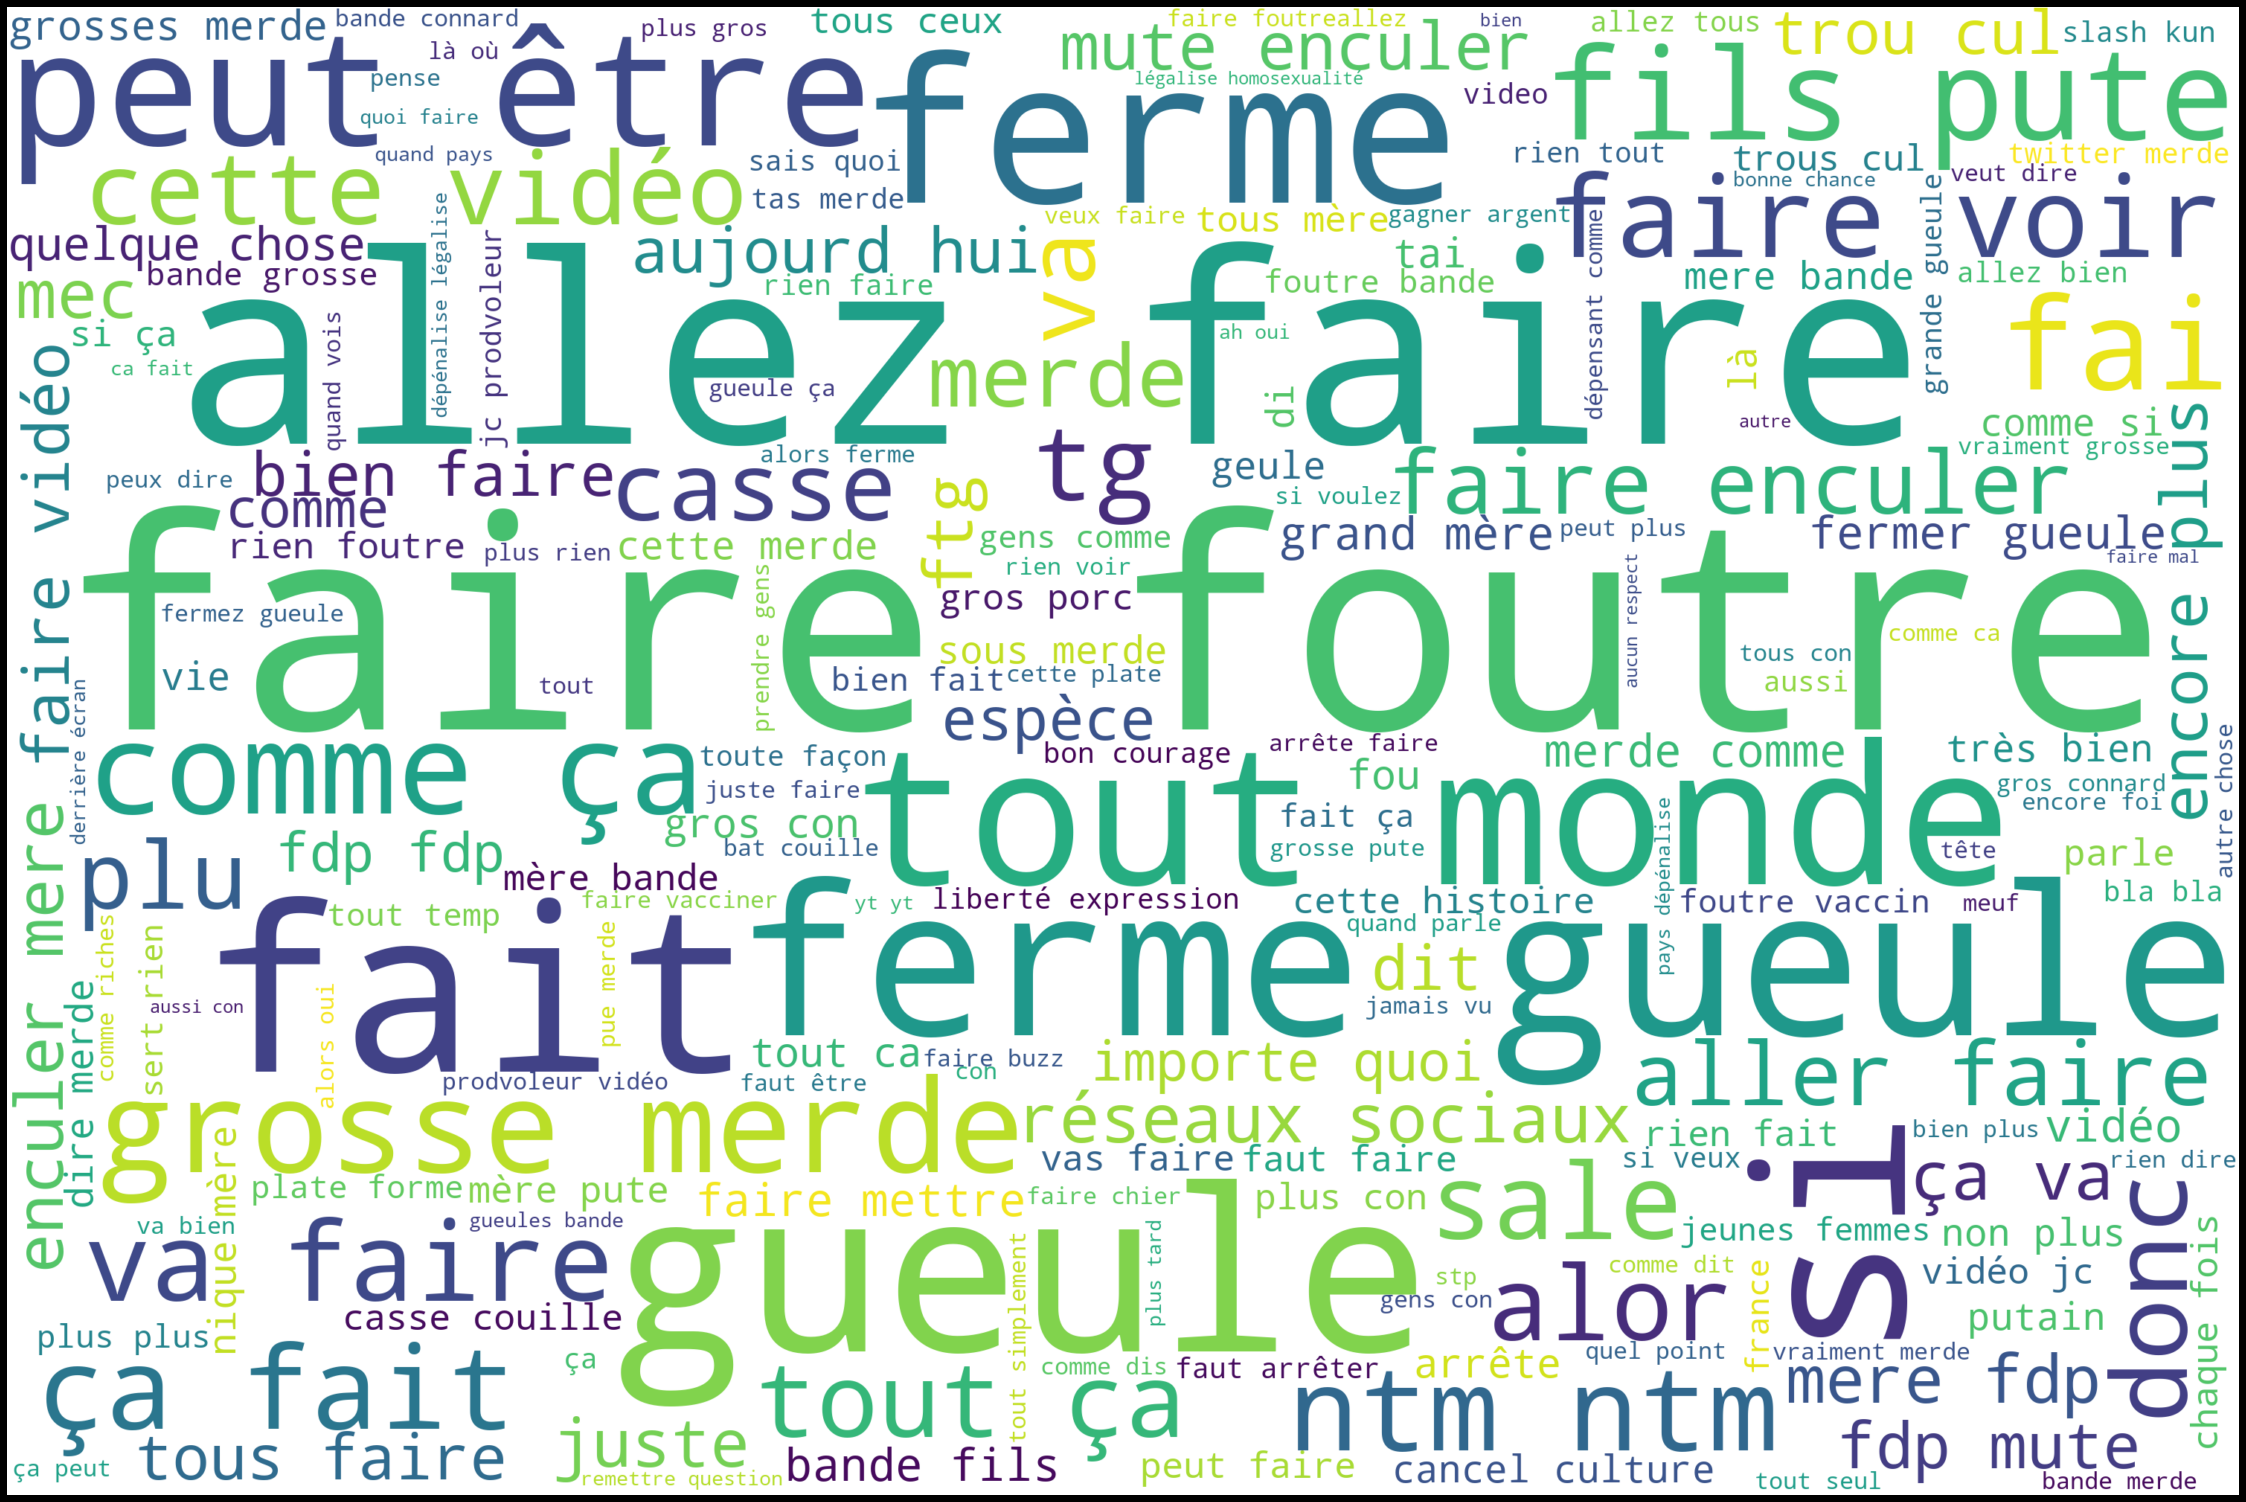

In [31]:
#Word Cloud on toxic posts by toxicity level
text = ''
dataset_vh = pd.DataFrame()
dataset_vh = dataset_wo_stop[dataset_wo_stop['Level']=='VERY_HIGH']
for news in dataset_vh.cleanSentence.values:
    text += news
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()
del dataset_vh, text

In [32]:
#Removing frequent words
#FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
FREQWORDS = ['de', 'est', 'la', 'et', 'le','les','c','que','des','a','un','en','à', 'pour','qui', 'l', 'd', 'une', 'ce', 'mais', 'qu', 'ne', 'ça', 'dans','du', 'sur', 'avec', 'tout', 'au', 'si', 'comme']

dataset_wo_freq = dataset.copy()

def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

dataset_wo_freq['cleanSentence'] = dataset_wo_freq['cleanSentence'].apply(remove_freqwords)
dataset_wo_freq.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose île je m abonne ta chaine tu t a...,[]
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t kiko mdr,[]
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[]
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta mono sourcils,[😂]
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[]
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce gamin,"[😂, 😂]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,quoi cette mode ou presque youtubeurs joue jeu...,[]
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,il dessus lois je fais reunions travail tous j...,[]


In [33]:
#Checking frequent words
cnt_frq = Counter()
for text in dataset_wo_freq["cleanSentence"].values:
    for word in text.split():
        cnt_frq[word] += 1
        
cnt_frq.most_common(20)

[('pas', 92356),
 ('je', 80306),
 ('il', 67932),
 ('tu', 65680),
 ('vous', 53252),
 ('on', 44948),
 ('j', 42214),
 ('t', 33397),
 ('ta', 29548),
 ('n', 28819),
 ('plus', 28111),
 ('fait', 26564),
 ('faire', 26072),
 ('ai', 24814),
 ('se', 24618),
 ('merde', 22899),
 ('ou', 21633),
 ('bien', 21143),
 ('y', 20733),
 ('sont', 20577)]

### Tokenizing

In [34]:
dataset['finalSentence'] = dataset['cleanSentence'].apply(word_tokenize)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,finalSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]","[t, pas, bo]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]","[t, es, vilain]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[],"[je, te, propose, un, d, île, je, m, abonne, à..."
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],"[t, un, kiko, mdr]"
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],"[moi, mdr, t, trop, nul]"
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂],"[ta, un, mono, sourcils]"
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],"[grosse, merdes]"
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]","[espèce, de, gamin]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[],"[c, est, quoi, cette, mode, ou, presque, tout,..."
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[],"[et, il, est, au, dessus, des, lois, je, fais,..."


In [35]:
dataset_wo_stop['finalSentence'] = dataset_wo_stop['cleanSentence'].apply(word_tokenize)
dataset_wo_stop.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,finalSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,bo,"[😂, 😂, 🥃]",[bo]
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",[vilain]
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,propose île abonne chaine abonner chaîne youtu...,[],"[propose, île, abonne, chaine, abonner, chaîne..."
3,T un kiko mdr,Insult,LOW,USER,1,13,4,kiko mdr,[],"[kiko, mdr]"
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,mdr trop nul,[],"[mdr, trop, nul]"
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,mono sourcils,[😂],"[mono, sourcils]"
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],"[grosse, merdes]"
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce gamin,"[😂, 😂]","[espèce, gamin]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,quoi cette mode presque tout youtubeurs joue j...,[],"[quoi, cette, mode, presque, tout, youtubeurs,..."
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,dessus lois fais reunions travail tous jours v...,[],"[dessus, lois, fais, reunions, travail, tous, ..."


In [36]:
dataset_wo_freq['finalSentence'] = dataset_wo_freq['cleanSentence'].apply(word_tokenize)
dataset_wo_freq.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,finalSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]","[t, pas, bo]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]","[t, es, vilain]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose île je m abonne ta chaine tu t a...,[],"[je, te, propose, île, je, m, abonne, ta, chai..."
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t kiko mdr,[],"[t, kiko, mdr]"
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],"[moi, mdr, t, trop, nul]"
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta mono sourcils,[😂],"[ta, mono, sourcils]"
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],"[grosse, merdes]"
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce gamin,"[😂, 😂]","[espèce, gamin]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,quoi cette mode ou presque youtubeurs joue jeu...,[],"[quoi, cette, mode, ou, presque, youtubeurs, j..."
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,il dessus lois je fais reunions travail tous j...,[],"[il, dessus, lois, je, fais, reunions, travail..."


In [37]:
#Alternative: Keeping only 60k neutral examples for a more balanced dataset

remove_n = len(dataset[dataset.Class == 0]) - 60000
neutralIndices = dataset[dataset.Class == 0].index
drop_indices = np.random.choice(neutralIndices, remove_n)
short_dataset = dataset.drop(index = drop_indices)
short_dataset

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,finalSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]","[t, pas, bo]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]","[t, es, vilain]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[],"[je, te, propose, un, d, île, je, m, abonne, à..."
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],"[t, un, kiko, mdr]"
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],"[moi, mdr, t, trop, nul]"
...,...,...,...,...,...,...,...,...,...,...
394584,@franceinfo Elle en sait quelque chose @nadine...,Neutral,NONE,UNDEFINED,0,58,8,elle en sait quelque chose morano,"[🤭, 😁, 😁]","[elle, en, sait, quelque, chose, morano]"
394585,tu joue sur fortnite sur mobile si oui ajt oi...,Neutral,NONE,UNDEFINED,0,51,11,tu joue sur fortnite sur mobile si oui ajt oim...,[],"[tu, joue, sur, fortnite, sur, mobile, si, oui..."
394587,@NicolasCatard @IntelFrance le mien il a deja ...,Neutral,NONE,UNDEFINED,0,109,17,le mien il a deja 4 ans je participe avec plai...,[],"[le, mien, il, a, deja, 4, ans, je, participe,..."
394590,Moi aussi je t'ai demandé si tu étais la premi...,Neutral,NONE,UNDEFINED,0,85,18,moi aussi je t ai demandé si tu étais la premi...,[],"[moi, aussi, je, t, ai, demandé, si, tu, étais..."


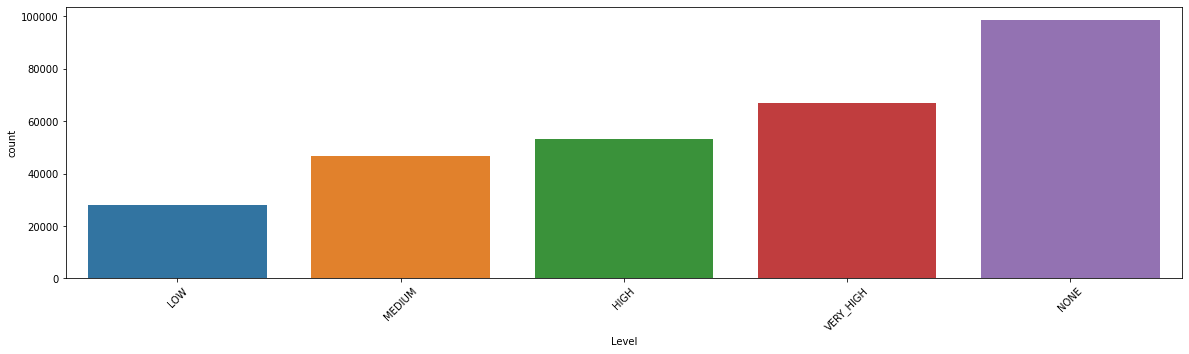

In [38]:
plt.figure(figsize=(20,5))
chart = sns.countplot("Level", data=short_dataset)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [39]:
simpleDataset = short_dataset[['cleanSentence', 'Level']].copy()
simpleDataset.head()

,cleanSentence,Level
0,t pas bo,LOW
1,t es vilain,LOW
2,je te propose un d île je m abonne à ta chaine...,LOW
3,t un kiko mdr,LOW
4,moi mdr t trop nul,LOW


In [40]:
simpleTrain, simpleTest = train_test_split(simpleDataset, test_size=0.2)
print(simpleTrain.shape, simpleTest.shape)

(235038, 2) (58760, 2)


### Creating final datasets

In [88]:
final_dataset = dataset_wo_freq.copy()

In [89]:
#Tokenizing Text with Keras -> Representing each word by a number
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(final_dataset["finalSentence"])

X_tok = tokenizer.texts_to_sequences(final_dataset["finalSentence"])


In [90]:
X_tok[0][:10]

[8, 1, 5492]

In [91]:
#Lets check few word to numerical representation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print("{} -> {}".format(word, num))
    if num == 10:
        break        

pas -> 1
je -> 2
il -> 3
tu -> 4
vous -> 5
on -> 6
j -> 7
t -> 8
ta -> 9
n -> 10


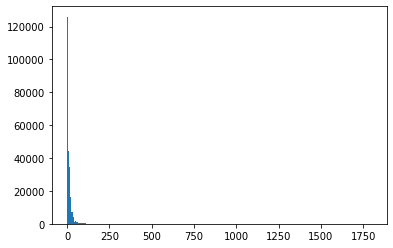

In [92]:
# Making histogram for no of words in sentences shows that most news sentences are under 150 words.
plt.hist([len(x) for x in X_tok], bins=500)
plt.show()

In [93]:
#Lets keep all sentences to 150, add padding to news with less than 150 words and truncating long ones
maxlen = 150 

#Making all news of size maxlen defined above, padding with 0 when needed
X_tok = pad_sequences(X_tok, maxlen=maxlen)

In [94]:
# Embedding Layer used in Keras creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [95]:
#Encoding labels as one-hot vectors
y = final_dataset["Level"]

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
print(y)

0          LOW
1          LOW
2          LOW
3          LOW
4          LOW
          ... 
394588    NONE
394589    NONE
394590    NONE
394591    NONE
394592    NONE
Name: Level, Length: 394592, dtype: object


In [96]:
labels_mapping = dict(zip(encoder.classes_,encoder.transform(encoder.classes_)))
labels_mapping

{'HIGH': 0, 'LOW': 1, 'MEDIUM': 2, 'NONE': 3, 'VERY_HIGH': 4}

In [97]:
# convert integers to dummy variables (i.e. one hot encoded)
onehot_y = np_utils.to_categorical(encoded_y)

In [98]:
#Encoding targets as one-hot vectors
targets = final_dataset["Target"]
encoder = LabelEncoder()
encoder.fit(targets)
encoded_targets = encoder.transform(targets)
print(targets)

0              USER
1              USER
2              USER
3              USER
4              USER
            ...    
394588    UNDEFINED
394589    UNDEFINED
394590    UNDEFINED
394591    UNDEFINED
394592    UNDEFINED
Name: Target, Length: 394592, dtype: object


In [99]:
onehot_targets = np_utils.to_categorical(encoded_targets)
onehot_targets

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [100]:
targets_mapping = dict(zip(encoder.classes_,encoder.transform(encoder.classes_)))
targets_mapping

{'AUTHOR_OF_COMMENT': 0,
 'EVERYONE': 1,
 'GROUP': 2,
 'SINGLE_PERSON': 3,
 'UNDEFINED': 4,
 'USER': 5,
 'USER_FAMILY': 6}

In [101]:
#Creating input and output sets
X_train_tok, X_test_tok, X_train_targets, X_test_targets, y_train_tok, y_test_tok = train_test_split(X_tok, onehot_targets, onehot_y, test_size = 0.2) 

# Vectorization

In [102]:
EMBEDDING_DIM = 200

In [103]:
# Function to create weight matrix between word-index and vectors from gensim models
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        try: 
          weight_matrix[i] = model[word]
        except:
          pass
    return weight_matrix

### Via TF-IDF

In [48]:
X_simpleTrain = simpleTrain['cleanSentence'].to_numpy()
y_simpleTrain = simpleTrain['Level'].to_numpy()

X_simpleTest = simpleTest['cleanSentence'].to_numpy()
y_simpleTest = simpleTest['Level'].to_numpy()

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_simpleTrain_tfidf = vectorizer.fit_transform(X_simpleTrain)
X_simpleTest_tfidf = vectorizer.transform(X_simpleTest)

In [50]:
X_simpleTrain_tfidf.shape

(235060, 89269)

In [51]:
X_simpleTrain[:10]

array(['trop nul ta video sale jaloux',
       'pour avoir beatrice il faut la parler',
       'en gros le peuple devient con et exprime sa connerie parce qu on lui donne les moyens ok jusque là je le suis par contre sa hauteur de diplômé qui explique qu on est en général trop con pour s exprimer sur quoi que ce soit là je decroche monsieur le philosophe exprimez donc l idée que les gouvernements successifs ont tout fait pour priver les citoyens d accéder aux connaissances nécessaires pour réfléchir ce qui a entraîner des pensées extrémistes non canalisées par manque de savoir et là on sera d accord parce que le côté donneur de leçon sans explication ça fait légèrement macroniste genre une élie sait les autres non donc fermez vos gueules c est pas très philosophique c est même très stérile comme réflexion pronez la connaissance la réforme de l éducation nationale mais ne reprochez pas aux gens d essayer d exprimer leurs émotions aussi mal retranscris qu elles soient',
       'quand on 

In [52]:
y_simpleTrain[:10]

array(['MEDIUM', 'NONE', 'HIGH', 'NONE', 'VERY_HIGH', 'NONE', 'NONE',
       'LOW', 'NONE', 'HIGH'], dtype=object)

### Via FastText

In [53]:
fasttext_model = gensim.models.FastText(sentences=final_dataset["finalSentence"], size=EMBEDDING_DIM, window=5, min_count=5)

In [54]:
len(fasttext_model.wv.vocab)

36605

In [55]:
fasttext_model.wv["merde"]

array([ 1.1284579 ,  0.6026093 ,  0.55194414, -1.4858775 , -1.8394794 ,
       -3.0810142 , -0.940217  , -1.6027595 , -1.5497886 , -0.85429865,
       -0.6348115 , -1.8178934 ,  2.1839948 , -1.6538231 , -0.85423   ,
       -1.5764794 ,  1.4149851 ,  1.0057323 , -0.36474034,  0.29080233,
       -0.21080719, -0.17950217, -0.45694226,  1.8594996 , -2.1465688 ,
        0.2735612 ,  0.3968396 , -0.62402505, -0.9700226 , -1.2724721 ,
        1.8486054 ,  0.15272905,  0.54489774, -0.37184393,  0.6777381 ,
        2.389091  , -0.8056522 ,  0.8209127 ,  0.25181684, -1.0788106 ,
        0.50884855, -1.0748245 , -1.5625927 ,  2.1265693 ,  0.769541  ,
        2.002416  ,  0.7465693 ,  0.2287906 ,  0.11381675,  0.21265097,
       -1.9339    , -0.12194537, -0.7238728 , -2.128207  , -1.4337852 ,
       -1.9397132 , -2.0834067 , -1.2747929 , -1.898521  ,  0.45629272,
       -1.0381802 ,  1.0910054 , -2.6330535 ,  1.1270115 ,  2.9112854 ,
       -0.17099997,  1.5804169 , -1.9675343 , -0.30740622, -3.94

In [56]:
print(fasttext_model.wv.most_similar("merde"))

[('merdebfmmerde', 0.9710953235626221), ('dmerde', 0.9606221318244934), ('merdeee', 0.9603695273399353), ('bfmerde', 0.9471138715744019), ('merdeu', 0.9379007816314697), ('merdeeee', 0.9377528429031372), ('emerde', 0.9298129677772522), ('merddd', 0.9261928796768188), ('merd', 0.9223754405975342), ('démerde', 0.9182571172714233)]


In [57]:
ft_embedding_vectors = get_weight_matrix(fasttext_model, word_index)

### Via Word2Vec

In [104]:
w2v_model = gensim.models.Word2Vec(sentences=final_dataset["finalSentence"], size=EMBEDDING_DIM, window=5, min_count=5)

In [105]:
len(w2v_model.wv.vocab)

36574

In [106]:
w2v_model["merde"]

array([-8.34338546e-01,  1.31862557e+00,  2.77744412e+00, -1.32442558e+00,
       -8.72185230e-01, -1.62153709e+00, -2.21541238e+00, -9.96507645e-01,
        1.36319771e-01, -2.96677947e+00, -1.38367295e+00, -1.48182362e-01,
       -1.69819072e-01, -1.32264447e+00,  2.34188437e+00, -1.34601080e+00,
        1.00551462e+00, -1.16229737e+00, -9.58100855e-02, -1.83610141e+00,
       -1.76030099e-02,  2.75804639e+00,  9.23195899e-01, -9.09920454e-01,
        2.29605466e-01,  1.02463722e+00, -1.97622597e+00, -8.24178874e-01,
        2.78939605e+00, -2.66538143e-01,  9.91411924e-01, -6.74902499e-01,
       -2.37990546e+00, -3.36137056e-01, -3.86567920e-01,  1.85390234e+00,
        2.27037281e-01, -8.24585482e-02,  4.73226845e-01, -1.25953484e+00,
       -9.91181433e-01, -9.37154710e-01,  7.34403253e-01,  1.49249172e+00,
       -1.13513863e+00,  4.51566875e-01, -2.22086653e-01,  6.08200505e-02,
       -9.81391013e-01,  4.93388474e-01, -6.84949994e-01,  9.93266463e-01,
       -2.20894551e+00, -

In [107]:
print(w2v_model.wv.most_similar("merde"))

[('merdes', 0.5435906648635864), ('conneries', 0.43971049785614014), ('salopards', 0.3830909729003906), ('mrd', 0.3745390772819519), ('vermine', 0.3613179624080658), ('arnaque', 0.35227787494659424), ('daube', 0.3520646095275879), ('connerie', 0.34891146421432495), ('chimio', 0.34687548875808716), ('dégueulasse', 0.33676257729530334)]


In [108]:
w2v_embedding_vectors = get_weight_matrix(w2v_model, word_index)

### Via FastText Pretrained vectors

In [ ]:
!pip install fasttext

In [ ]:
import fasttext.util
fasttext.util.download_model('fr', if_exists='ignore')
ft = fasttext.load_model('cc.fr.300.bin')

In [ ]:
ft.get_dimension()

In [ ]:
#Optional - reduce vectors dimensions
#fasttext.util.reduce_model(ft, 100)
#ft.get_dimension()

In [ ]:
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz

### Via Universal Sentence Encoder

# Modelization

## Baseline - Prediction based on sentence only

### Via SVM (Baseline)

In [99]:
from sklearn.svm import SVC

linear_svm_classifier_tfidf = SVC(kernel = "linear").fit(X_train_tok,y_train_tok)

ValueError: ignored

In [ ]:
train_acc_svm = metrics.accuracy_score(y_simpleTrain, linear_svm_classifier_tfidf.predict(X_train_tok))
print("Training accuracy: ", train_acc_svm)

In [ ]:
predictions_svm_tfidf = linear_svm_classifier_tfidf.predict(X_test_tok)
print(predictions_svm_tfidf)

In [ ]:
print(classification_report(y_test_tok, predictions_svm_tfidf))

### Via FastText

In [ ]:
label_mapping = {'NONE': '__label__0',
                     'LOW': '__label__1',
                     'MEDIUM': '__label__2',
                     'HIGH': '__label__3',
                     'VERY_HIGH': '__label__4'}

In [ ]:
#np.savetxt(r'Model_training_data.txt', dataset.values, fmt='%d')

In [ ]:
#model = fasttext.train_supervised(input=train_fn,
#                                  pretrainedVectors=pretrainedvec_fn,
#                                  dim=300, 
#                                  wordNgrams=2, 
#                                  minCount=3, 
#                                  epoch=20, 
#                                  loss='ova')

### Via Bi-LSTM

In [54]:
#Defining Neural Network
lstm_model = Sequential()
#Non-trainable embeddidng layer
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
#lstm_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
#Bi-LSTM
lstm_model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
lstm_model.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm_model.add(Dense(5, activation='softmax'))
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [55]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 200)          26505600  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dense (Dense)                (None, 200)               51400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1005      
Total params: 26,894,901
Trainable params: 389,301
Non-trainable params: 26,505,600
_________________________________________________________________


In [ ]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(X_train_tok, y_train_tok, validation_split=0.2, epochs=4, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 252539 samples, validate on 63135 samples
Epoch 1/4
252539/252539 [==============================] - 2944s 12ms/sample - loss: 0.7124 - acc: 0.7486 - val_loss: 0.5740 - val_acc: 0.7992
Epoch 2/4
252539/252539 [==============================] - 2949s 12ms/sample - loss: 0.5649 - acc: 0.8035 - val_loss: 0.5072 - val_acc: 0.8272
Epoch 3/4
252539/252539 [==============================] - 2992s 12ms/sample - loss: 0.5131 - acc: 0.8224 - val_loss: 0.4713 - val_acc: 0.8431
Epoch 4/4
101344/252539 [===========>..................] - ETA: 28:34 - loss: 0.4853 - acc: 0.8307

In [ ]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
lstm_pred = (lstm_model.predict(X_test_tok) >= 0.5).astype("int")

In [ ]:
print(classification_report(y_test_tok, lstm_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test_tok.argmax(axis=1), lstm_pred.argmax(axis=1))
print(conf_matrix)

In [ ]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

### Via CamemBERT

==> https://www.kaggle.com/houssemayed/camembert-for-french-tweets-classification

==> https://colab.sandbox.google.com/drive/1KgWs_sYNEL_ZnnZ_p7eTSevVb5xXx1Hu?usp=sharing#scrollTo=ELf3ehrNxY3k

In [62]:
!pip install transformers
!pip install sentencepiece
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import AdamW

epochs = 5
MAX_LEN = 100
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize CamemBERT tokenizer
cam_tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

In [58]:
# Creates list of texts and labels
text = dataset['cleanSentence'].to_list()
labels = list(encoded_y)

#user tokenizer to convert sentences into tokenizer
input_ids  = [cam_tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN) for sent in text]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]  
    attention_masks.append(seq_mask)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [59]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=42, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [60]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=5)
model.to(device)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

RuntimeError: ignored

In [ ]:
#Defining the parameters and metrics to optimize
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=10e-8)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Store our loss and accuracy for plotting if we want to visualize training evolution per epochs after the training process
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):  
    # Tracking variables for training
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs[0]
        # Add it to train loss list
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
    
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Validation of the model
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]
    
        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

## Next stage - Prediction based on sentence + target

### Via FastText

### Via Bi-LSTM

In [117]:
input1 = Input(shape=(maxlen,))
embed1 = Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False)(input1)
bdlstm1 = Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))(embed1)
dense1 = Dense(EMBEDDING_DIM, activation='relu')(bdlstm1)

input2 = Input(shape=(7,))
dense2 = Dense(EMBEDDING_DIM, activation='relu')(input2)

dense = Concatenate()([dense1, dense2])
out = Dense(5, activation='softmax')(dense)
bilstm_model = keras.Model(inputs = [input1, input2], outputs = out)
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [118]:
bilstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 150, 200)     26499400    input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 256)          336896      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 7)]          0                                            
____________________________________________________________________________________________

In [119]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

bilstm_history = bilstm_model.fit([X_train_tok, X_train_targets], y_train_tok, validation_split=0.2, epochs=6, batch_size = 512, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Train on 252538 samples, validate on 63135 samples
Epoch 1/6
252538/252538 [==============================] - 183s 726us/sample - loss: 0.5513 - acc: 0.7787 - val_loss: 0.4118 - val_acc: 0.8313
Epoch 2/6
252538/252538 [==============================] - 183s 727us/sample - loss: 0.3940 - acc: 0.8413 - val_loss: 0.3488 - val_acc: 0.8630
Epoch 3/6
252538/252538 [==============================] - 183s 724us/sample - loss: 0.3423 - acc: 0.8642 - val_loss: 0.3066 - val_acc: 0.8810
Epoch 4/6
252538/252538 [==============================] - 185s 732us/sample - loss: 0.3053 - acc: 0.8803 - val_loss: 0.2800 - val_acc: 0.8944
Epoch 5/6
252538/252538 [==============================] - 182s 720us/sample - loss: 0.2808 - acc: 0.8909 - val_loss: 0.2643 - val_acc: 0.9017
Epoch 6/6
252538/252538 [==============================] - 183s 725us/sample - loss: 0.2624 - acc: 0.8979 - val_loss: 0.2497 - val_acc: 0.9084


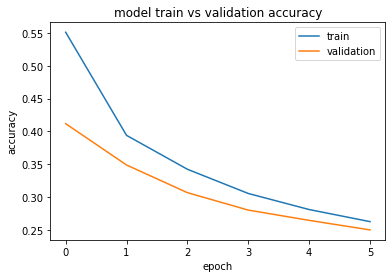

In [120]:
plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['val_loss'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [121]:
bilstm_pred = (bilstm_model.predict([X_test_tok, X_test_targets]) >= 0.5).astype("int")

In [122]:
print(classification_report(y_test_tok, bilstm_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     10573
           1       0.93      0.81      0.86      5666
           2       0.86      0.67      0.75      9327
           3       1.00      1.00      1.00     39733
           4       0.87      0.84      0.85     13620

   micro avg       0.93      0.89      0.91     78919
   macro avg       0.89      0.82      0.85     78919
weighted avg       0.93      0.89      0.91     78919
 samples avg       0.89      0.89      0.89     78919



In [123]:
conf_matrix = confusion_matrix(y_test_tok.argmax(axis=1), bilstm_pred.argmax(axis=1))
print(conf_matrix)

[[ 9210   121   444     1   797]
 [  675  4567   266     0   158]
 [ 2083   167  6258     1   818]
 [    3     1     1 39727     1]
 [ 1841    81   311     0 11387]]


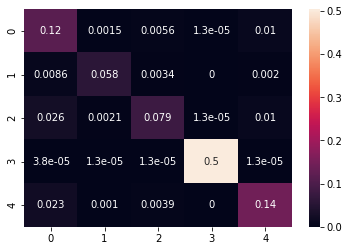

In [124]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [70]:
#lstm_model.save("BiLSTM")

### Via CamemBERT

# Target prediction

### By training a classifier based on current "Target" label?

#### Via Bi-LSTM

In [109]:
#Defining Neural Network
lstm_model = Sequential()
#Non-trainable embeddidng layer
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
#lstm_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
#Bi-LSTM
lstm_model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
lstm_model.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm_model.add(Dense(7, activation='softmax'))
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [110]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 200)          26499400  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_3 (Dense)              (None, 200)               51400     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 1407      
Total params: 26,889,103
Trainable params: 389,703
Non-trainable params: 26,499,400
_________________________________________________________________


In [111]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(X_train_tok, X_train_targets, validation_split=0.2, epochs=6, batch_size =512, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Train on 252538 samples, validate on 63135 samples
Epoch 1/6
252538/252538 [==============================] - 185s 733us/sample - loss: 0.6982 - acc: 0.7636 - val_loss: 0.5370 - val_acc: 0.8146
Epoch 2/6
252538/252538 [==============================] - 184s 729us/sample - loss: 0.5090 - acc: 0.8232 - val_loss: 0.4414 - val_acc: 0.8443
Epoch 3/6
252538/252538 [==============================] - 185s 731us/sample - loss: 0.4348 - acc: 0.8480 - val_loss: 0.3815 - val_acc: 0.8686
Epoch 4/6
252538/252538 [==============================] - 181s 718us/sample - loss: 0.3826 - acc: 0.8668 - val_loss: 0.3351 - val_acc: 0.8863
Epoch 5/6
252538/252538 [==============================] - 182s 719us/sample - loss: 0.3453 - acc: 0.8786 - val_loss: 0.3021 - val_acc: 0.8977
Epoch 6/6
252538/252538 [==============================] - 181s 716us/sample - loss: 0.3162 - acc: 0.8892 - val_loss: 0.2843 - val_acc: 0.9050


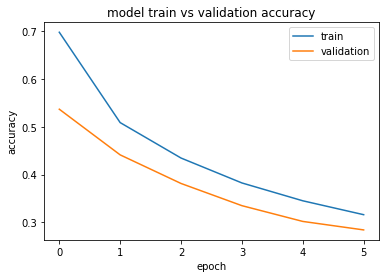

In [112]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [113]:
lstm_pred = (lstm_model.predict(X_test_tok) >= 0.5).astype("int")

In [114]:
print(classification_report(X_test_targets, lstm_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       526
           1       0.96      0.98      0.97      3338
           2       0.87      0.91      0.89      7125
           3       0.87      0.89      0.88      7393
           4       0.93      0.95      0.94     39729
           5       0.91      0.77      0.83     19520
           6       0.94      0.94      0.94      1288

   micro avg       0.91      0.90      0.90     78919
   macro avg       0.91      0.91      0.91     78919
weighted avg       0.91      0.90      0.90     78919
 samples avg       0.90      0.90      0.90     78919



In [115]:
conf_matrix = confusion_matrix(X_test_targets.argmax(axis=1), lstm_pred.argmax(axis=1))
print(conf_matrix)

[[  500     0     2     0    19     5     0]
 [   14  3268     2     6    23    25     0]
 [  155     1  6449    72   124   324     0]
 [  227     1   104  6562   191   308     0]
 [  572    59   280   315 37607   874    22]
 [  631    67   564   569  2548 15081    60]
 [   36     0     3     4    12    19  1214]]


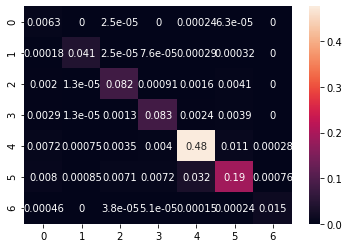

In [116]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

### Via semantic role labeling ?

### Via lexical features analysis ?

### Via modified Aspect-Based Sentiment Analysis ?

# Data augmentation

### Via Google Translate

### Via Weakly Unsupervised Learning

# Feature analysis

### Sentiment analysis

In [53]:
!pip install vaderSentiment_fr
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [54]:
vader.polarity_scores('Moi mdr t trop nul')

{'compound': 0.4779, 'neg': 0.206, 'neu': 0.345, 'pos': 0.449}

In [55]:
vader.polarity_scores_max('Moi mdr t trop nul')

Processing time : 9.083747863769531e-05


{'compound': 0.4779, 'neg': 0.206, 'neu': 0.345, 'pos': 0.449}

In [56]:
def get_vader_sent(val):
  if val >= 0.05:
    return "pos"
  elif val <= -0.05:
    return "neg"
  else:
    return "neu"

In [61]:
# Checking with non tokenized toxic data
vader_toxic = []
sentiments_toxic = dataset.loc[dataset['Class'] == 1]["cleanSentence"].tolist()

for i in range(len(sentiments_toxic)):
  vader_toxic.append(vader.polarity_scores(str(sentiments_toxic[i])))

comp = []
pos = []
neg = []
neu = []
for j in range(len(vader_toxic)):
  comp.append(vader_toxic[j]['compound'])
  pos.append(vader_toxic[j]['pos'])
  neg.append(vader_toxic[j]['neg'])
  neu.append(vader_toxic[j]['neu'])

print("Compound: ",sum(comp)/len(comp), "Positive: ",sum(pos)/len(pos),"Neutral: ", sum(neu)/len(neu),"Negative :", sum(neg)/len(neg))

Compound:  -0.13845125929507032 Positive:  0.06868095460782297 Neutral:  0.7195407851258535 Negative : 0.21178063445240752


In [62]:
# Checking with non tokenized clean data
vader_clean = []
sentiments_clean = dataset.loc[dataset['Class'] == 0]["cleanSentence"].tolist()

for i in range(len(sentiments_clean)):
  vader_clean.append(vader.polarity_scores(str(sentiments_clean[i])))

comp = []
pos = []
neg = []
neu = []
for j in range(len(vader_clean)):
  comp.append(vader_clean[j]['compound'])
  pos.append(vader_clean[j]['pos'])
  neg.append(vader_clean[j]['neg'])
  neu.append(vader_clean[j]['neu'])

print("Compound: ",sum(comp)/len(comp), "Positive: ",sum(pos)/len(pos),"Neutral: ", sum(neu)/len(neu),"Negative :", sum(neg)/len(neg))

Compound:  0.1103306954999951 Positive:  0.1261536849999933 Neutral:  0.8205530599999965 Negative : 0.053292799999998926


In [64]:
# Checking with non tokenized VERY toxic data
vader_toxic = []
sentiments_toxic = dataset.loc[dataset['Level'] == "HIGH"]["cleanSentence"].tolist()

for i in range(len(sentiments_toxic)):
  vader_toxic.append(vader.polarity_scores(str(sentiments_toxic[i])))

comp = []
pos = []
neg = []
neu = []
for j in range(len(vader_toxic)):
  comp.append(vader_toxic[j]['compound'])
  pos.append(vader_toxic[j]['pos'])
  neg.append(vader_toxic[j]['neg'])
  neu.append(vader_toxic[j]['neu'])

print("Compound: ",sum(comp)/len(comp), "Positive: ",sum(pos)/len(pos),"Neutral: ", sum(neu)/len(neu),"Negative :", sum(neg)/len(neg))

Compound:  -0.1677027025000968 Positive:  0.06561415345402831 Neutral:  0.7009890175793817 Negative : 0.23339883428913538
